In [1]:
import pandas as pd
import numpy as np
from bayes_approach import Bayesian_AB
import numpy as np
import arviz as az
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
query = '''
with precondition as (
    SELECT
    	DISTINCT(t.session_id) as session_id
    FROM
    	TRACKING t
        
    JOIN
        SESSION s on t.session_id = s.session_id
    WHERE
    	t.event_name = 'pages'
        AND t.page_type = 'PDP'
        AND t.event_day  >= '2021-08-01'
        AND t.platform_id = 0
        AND s.device_type in ('desktop', 'tablet')
        AND (s.is_bot is null OR s.is_bot = 0)
        AND s.has_tracking_consent = 1
        AND s.country_code = 'de'
        AND t.country_code = 'de'
), sessions as (
	SELECT
		t.session_id,
		s.session_day,
		t.ab_test_group_name as test_group
    FROM
    	TRACKING t
    JOIN
        SESSION s on t.session_id = s.session_id
    WHERE
    	t.event_day  >= '2021-08-09'
        AND s.session_day  >= '2021-08-10'
        AND t.ab_test_id = '209'
        AND t.platform_id = 0
        AND s.device_type in ('desktop', 'tablet')
        AND (s.is_bot is null OR s.is_bot = 0)
        AND s.has_tracking_consent = 1
        AND t.country_code = 'de'
        AND s.country_code = 'de'
        AND t.session_id in (SELECT session_id FROM precondition)
    GROUP BY
    	1, 2, 3
), leads as (

	SELECT
		sl.session_id,
		sl.session_day,
		1 as leads
	FROM
		SESSION_LEAD_LOOKUP sl
    JOIN
        LEAD l on sl.lead_id = l.lead_id
	WHERE
        sl.session_day >= '2021-08-10'
        AND sl.country_code = 'de' 
        AND l.IS_QUALITY_LEAD = 1
    GROUP BY
        1, 2
)
SELECT
    s.session_id,
	s.session_day,
	s.test_group,
	nvl(l.leads, 0) as leads
FROM
	sessions s
LEFT JOIN
	leads l on s.session_id = l.session_id
'''

In [4]:
E = Bayesian_AB(project_name='vertical_recommendation_PDP-desktop')

In [5]:
df = E.get_data(load_new=True, query=query)

In [6]:
df.sort_values(by=['session_day'])

,session_id,session_day,test_group,leads
0,ajs-7a6a271cc1e52cf101ec1df3ca8ef366,2021-08-10,show_vertically_variant,1
71446,ajs-7aa300abdc1d3e70153b343486fc710e,2021-08-10,show_vertically_variant,0
71441,ajs-5a40ea5feb7612d719b1565f010486a5,2021-08-10,show_vertically_variant,0
11877,ajs-8a725840d4017359f89b239c43aa6c40,2021-08-10,show_vertically_variant,0
71439,ajs-ce097e94f2c10a963d92ffd8c5458ff1,2021-08-10,show_vertically_variant,0
...,...,...,...,...
82636,ajs-1cdbb4f3add0c915e4ff251854da0a33,2021-08-17,show_carousel_control,0
53316,ajs-f632b0f794ba836228d19e1396ca3563,2021-08-17,show_carousel_control,0
96236,ajs-974b64877427327ab35b04cb8e9a8795,2021-08-17,show_vertically_variant,0
71327,ajs-bde0bf1dde08fe4cc8cd621124f3b0ed,2021-08-17,show_vertically_variant,0


In [7]:
c, v = E.prepare_data(df,
                      control_filter='show_carousel_control',
                      variant_filter='show_vertically_variant',
                      date_column='session_day',
                      sample_column='session_id',
                      conversion_column='leads',
                      test_column='test_group',
                      day_index=True
                     ) 
#control group & variant group

In [8]:
c

,session_id,leads
DAY,,
0,7906,65
1,6861,61
2,6667,53
3,6097,34
4,5356,28
5,6623,35
6,7896,65
7,7490,55


In [9]:
v

,session_id,leads
DAY,,
0,7817,56
1,6835,52
2,6631,49
3,6029,39
4,5008,19
5,6356,38
6,7880,56
7,7727,49


In [10]:
simulation_ImSa = E.posterior_analytic_importance_sampling(control=c,
                                                           variant=v)

In [11]:
simulation_ImSa

,simulations,day,variant_expected_loss,control_expected_loss,prob_variant_better_than_control,prob_variant_better_control_error,control_cvr,control_cvr_lower,control_cvr_upper,variant_cvr,variant_cvr_lower,variant_cvr_upper
0,1,0,0.001240,0.000182,0.225050,0.000581,0.00834597875569044,0.006461,0.010466,0.007289934774267809,0.005527,0.009292
1,1,1,0.001231,0.000068,0.131237,0.000432,0.00859909269415668,0.007174,0.010150,0.007438242118192985,0.006112,0.008892
2,1,2,0.001029,0.000054,0.127316,0.000424,0.008397089009143497,0.007220,0.009661,0.007423067888184167,0.006314,0.008619
3,1,3,0.000653,0.000095,0.223561,0.000576,0.007772491192387317,0.006769,0.008843,0.007212418539942886,0.006244,0.008250
4,1,4,0.000727,0.000051,0.151100,0.000467,0.0073580832497187505,0.006463,0.008310,0.006682754780025988,0.005824,0.007600
5,1,5,0.000521,0.000076,0.224653,0.000578,0.00701052844705406,0.006212,0.007857,0.006567040694968716,0.005787,0.007396
6,1,6,0.000598,0.000043,0.152700,0.000469,0.007213972325345933,0.006472,0.007995,0.006658361613471369,0.005940,0.007417
7,1,7,0.000644,0.000026,0.108872,0.000386,0.0072315931363619804,0.006540,0.007957,0.006613244911117252,0.005949,0.007312


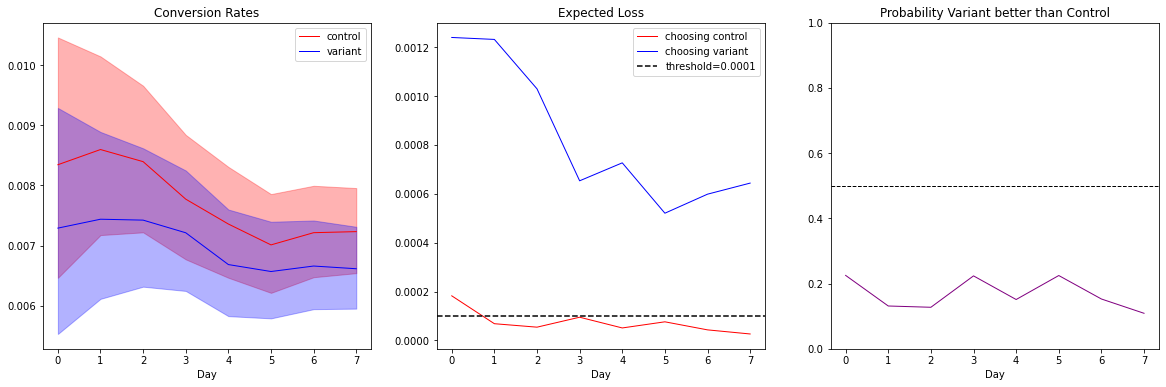

In [12]:
E.plot_expected_loss(simulation_ImSa)

In [13]:
E.get_results()

VALUE
GROUP   METRIC                                       
control CvR                                   0.00723
        sample size                             54896
        conversions                               396
        95% credible interval      (0.00654, 0.00796)
variant CvR                                   0.00661
        sample size                             54283
        conversions                               358
        95% credible interval      (0.00595, 0.00731)
outcome uplift                                -8.551%
        control expected loss             2.63873e-05
        variant expected loss              0.00064367
        prob (variant >= control)             10.887%
        standard error                    0.000386467